In [1]:
import os, glob, time, datetime
import numpy as np
import imageio
from PIL import Image
from collections import OrderedDict
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider
from common.function import init_embedding, interpolated_embedding_lookup
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image, tight_crop_image, centering_image, save_gif
from common.train import interpolation
from get_data.package import pickle_interpolation_data

### GPU Option

In [2]:
GPU = torch.cuda.is_available()
GPU

True

### Hyperparameter setting

In [3]:
FONTS_NUM = 25
EMBEDDING_NUM = 100
BATCH_SIZE = 18
IMG_SIZE = 128
EMBEDDING_DIM = 128

from_model_path = './model_checkpoint/'
data_dir = './interpolation/dataset/'
fixed_dir = './fixed_sample/'

### 150epoch trained model

In [4]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=FONTS_NUM).cuda()

In [5]:
restore = ['150-0604-10:42-Encoder.pkl', '150-0604-10:42-Decoder.pkl', '150-0604-10:42-Discriminator.pkl']

encoder_path, decoder_path, discriminator_path = restore
prev_epoch = int(encoder_path.split('-')[0])
En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
print("%d epoch trained model has restored" % prev_epoch)

150 epoch trained model has restored


### Embeddings

In [6]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

In [7]:
except_ = [1, 2, 3, 4, 22, 23, 24]
font_filter = [i for i in range(25)if i not in except_]
font_filter_plus = font_filter + [font_filter[0]]

interpolated_font_ids = [(i, font_filter_plus[font_filter.index(i)+1]) for i in font_filter]

step = 6
grids = list(np.linspace(0.3, 0.7, step))
grids = [0., 0.15] + grids + [0.85, 1.]
print(len(grids))

fixed_char_ids = torch.load(os.path.join(data_dir, 'fixed_char_ids.pkl')).numpy()

10


In [8]:
data_provider = TrainDataProvider(data_dir, train_name="interpolation_data.obj", val=False)
total_batches = data_provider.compute_total_batch_num(BATCH_SIZE)
print("total batches:", total_batches)

unpickled total 432 examples
train examples -> 432
total batches: 24


---

## Image Centering
- 저장한 image들이 각각 다른 source로 생성되어서, center가 다 안맞는다.

- centering을 따로 해줄 필요

In [9]:
grid_results = interpolation(data_provider, grids, fixed_char_ids, interpolated_font_ids, \
                             embeddings, En, De, batch_size=BATCH_SIZE, img_size=128, GPU=True)

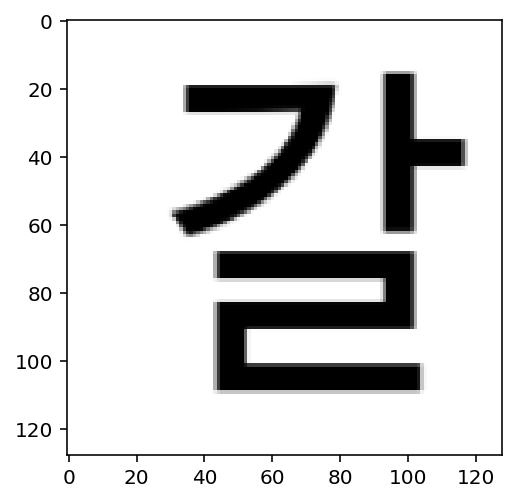

In [12]:
test_image = denorm_image(grid_results[(5, 6)][8][0].data).cpu().numpy().reshape(128, 128)
plt.imshow(test_image, cmap='gray')
plt.show()

- 이미지들이 중앙에 이쁘게 배열되어있지 않고 쏠려있다. 


- centering 필요

### 글씨를 tight하게 감싸도록 image crop

In [13]:
128 - sum(test_image[0])

0.0

- 거의 흰색이면 `128 - sum` 값이 1 이하

In [14]:
128 - sum(test_image[40])

33.91372546553612

- 글씨가 있는 부분은 `128 - sum` 값이 크다

In [15]:
def tight_crop_image(img, verbose=False, resize_fix_h=False):
    img_size = img.shape[0]
    full_white = img_size
    col_sum = np.where(full_white - np.sum(img, axis=0) > 1)
    row_sum = np.where(full_white - np.sum(img, axis=1) > 1)
    y1, y2 = row_sum[0][0], row_sum[0][-1]
    x1, x2 = col_sum[0][0], col_sum[0][-1]
    cropped_image = img[y1:y2, x1:x2]
    cropped_image_size = cropped_image.shape
    
    if verbose:
        print('(left x1, top y1):', (x1, y1))
        print('(right x2, bottom y2):', (x2, y2))
        print('cropped_image size:', cropped_image_size)
        
    if resize_fix_h:
        origin_h, origin_w = cropped_image.shape
        resize_w = int(origin_w / origin_h * resize_fix_h)
        resize_h = resize_fix_h
        if verbose:
            print('resize_h:', resize_h)
            print('resize_w:', resize_w, \
                  '[origin_w %d / origin_h %d * target_h %d]' % (origin_w, origin_h, target_h))
    
        # resize
        cropped_image = imresize(cropped_image, (resize_h, resize_w))
        cropped_image_size = cropped_image.shape
        
        if verbose:
            print('resized_image size:', cropped_image_size)
    
    return cropped_image, cropped_image_size

(left x1, top y1): (31, 15)
(right x2, bottom y2): (117, 109)
cropped_image size: (94, 86)


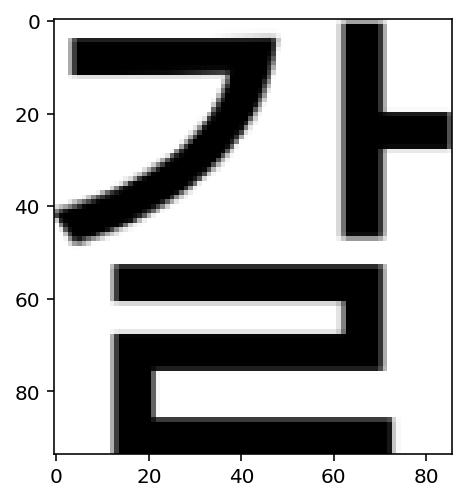

In [16]:
cropped_image, cropped_image_size = tight_crop_image(test_image, verbose=True)
plt.imshow(cropped_image, cmap='gray')
plt.show()

### 글씨가 중앙에 있는 새 tensor 만들기

In [17]:
def add_padding(img, image_size=128, verbose=False, pad_value=1):
    height, width = img.shape
    if verbose:
        print('original cropped image size:', img.shape)
    
    # Adding padding of x axis - left, right
    pad_x_width = (image_size - width) // 2
    pad_x = np.full((height, pad_x_width), pad_value, dtype=np.float32)
    img = np.concatenate((pad_x, img), axis=1)
    img = np.concatenate((img, pad_x), axis=1)
    
    width = img.shape[1]

    # Adding padding of y axis - top, bottom
    pad_y_height = (image_size - height) // 2
    pad_y = np.full((pad_y_height, width), pad_value, dtype=np.float32)
    img = np.concatenate((pad_y, img), axis=0)
    img = np.concatenate((img, pad_y), axis=0)
    
    # Match to original image size
    width = img.shape[1]
    if img.shape[0] % 2:
        pad = np.full((1, width), pad_value, dtype=np.float32)
        img = np.concatenate((pad, img), axis=0)
    height = img.shape[0]
    if img.shape[1] % 2:
        pad = np.full((height, 1), pad_value, dtype=np.float32)
        img = np.concatenate((pad, img), axis=1)

    if verbose:
        print('final image size:', img.shape)
    
    return img

In [21]:
centered_image = add_padding(cropped_image, verbose=True)

original cropped image size: (94, 86)
final image size: (128, 128)


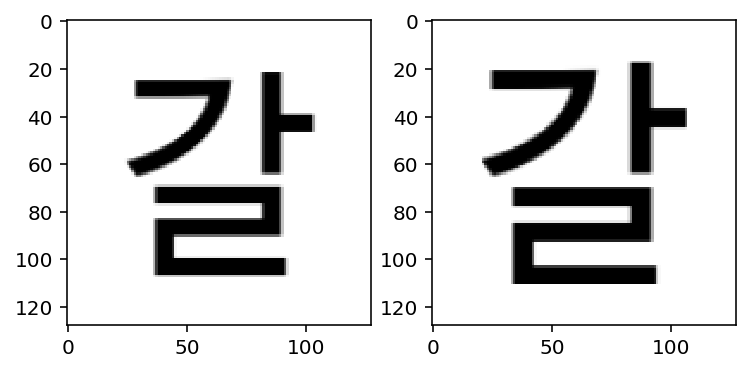

In [22]:
plt.subplot(121)
plt.imshow(test_image, cmap='gray')
plt.subplot(122)
plt.imshow(centered_image, cmap='gray')
plt.show()

Centering 됐다!

### 전체 함수 import 해서 사용

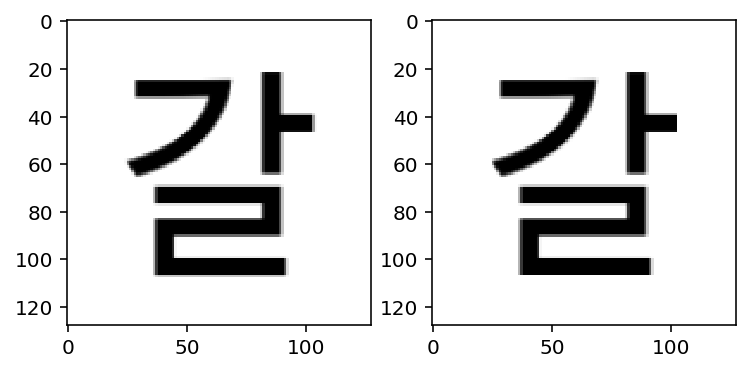

In [23]:
test_image = denorm_image(grid_results[(10, 11)][8][0].data).cpu().numpy().reshape(128, 128)
centered_image = centering_image(test_image)
plt.subplot(121)
plt.imshow(test_image, cmap='gray')
plt.subplot(122)
plt.imshow(centered_image, cmap='gray')
plt.show()

## Image size 폰트별 평균 사이즈로 맞추기

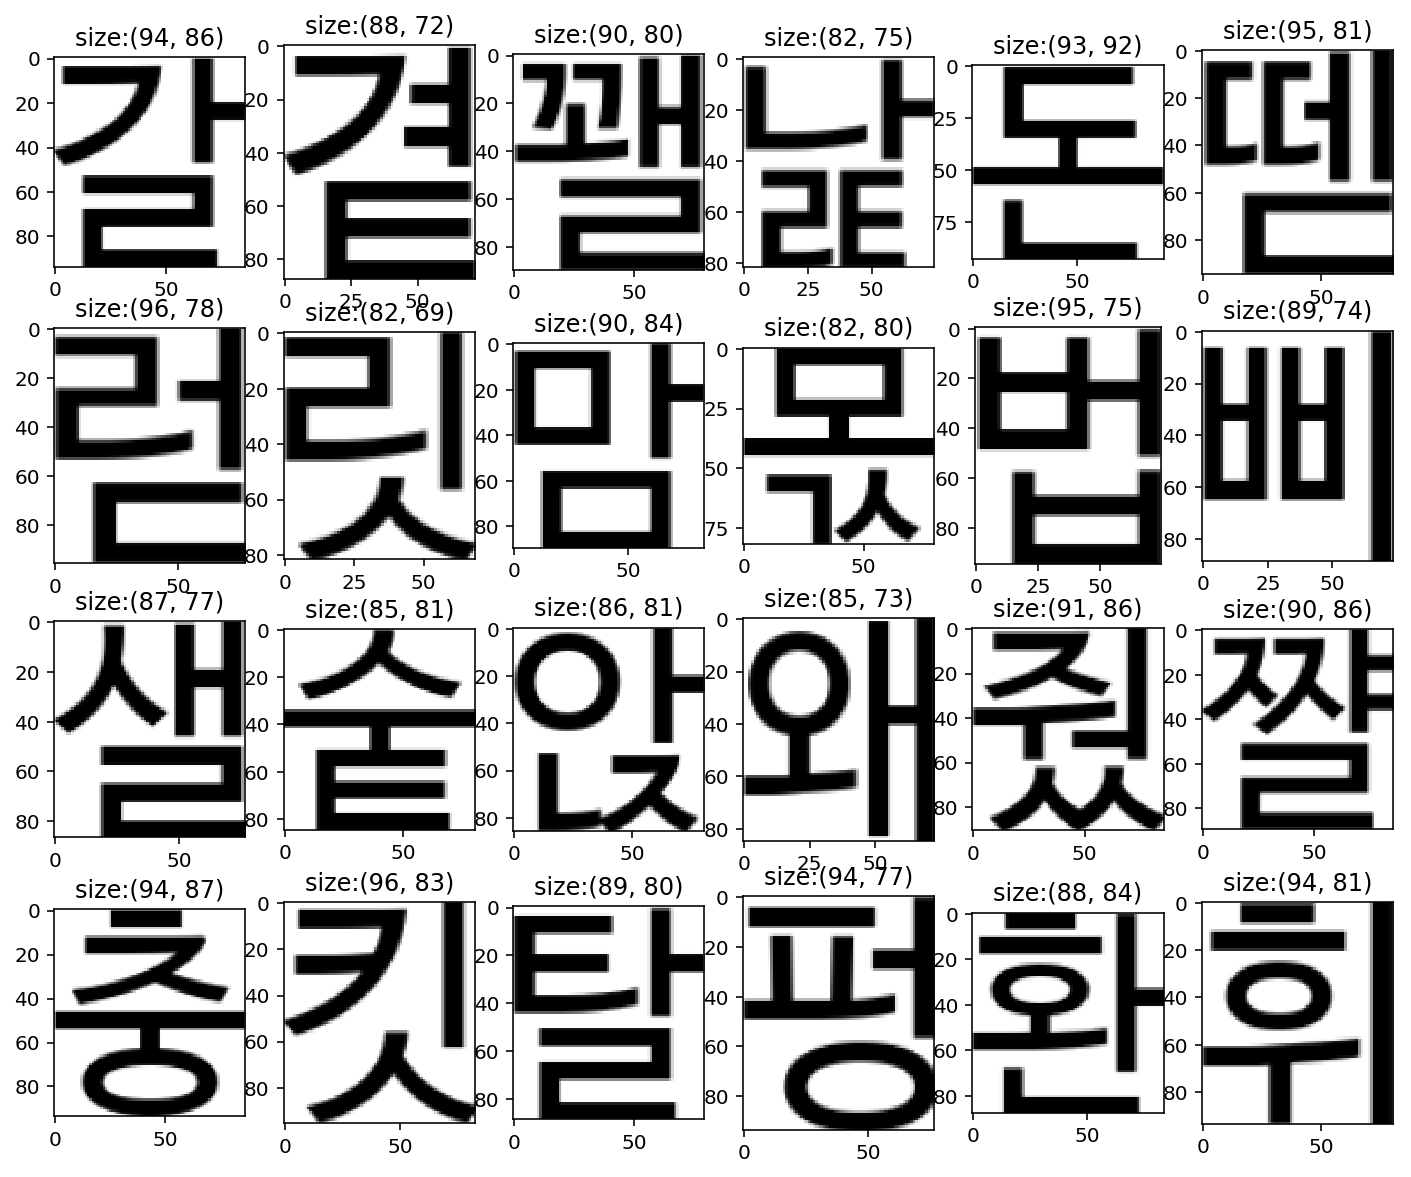

In [24]:
fontid = (0, 5)

plt.figure(figsize=(12, 10))
idx = 1
fake_images = np.array([grid_results[fontid][charid][0] for charid in fixed_char_ids])
for image in fake_images:
    image = image.cpu().detach().numpy()
    img, img_size = tight_crop_image(image.reshape(128, 128))
    plt.subplot(4, 6, idx)
    plt.imshow(img, cmap='gray')
    plt.title('size:' + str(img_size))
    idx += 1
plt.show()

- 크기가 전부 달라서 맞춰줘야 할 필요가 있다.

### `Height=100` 으로 맞추기

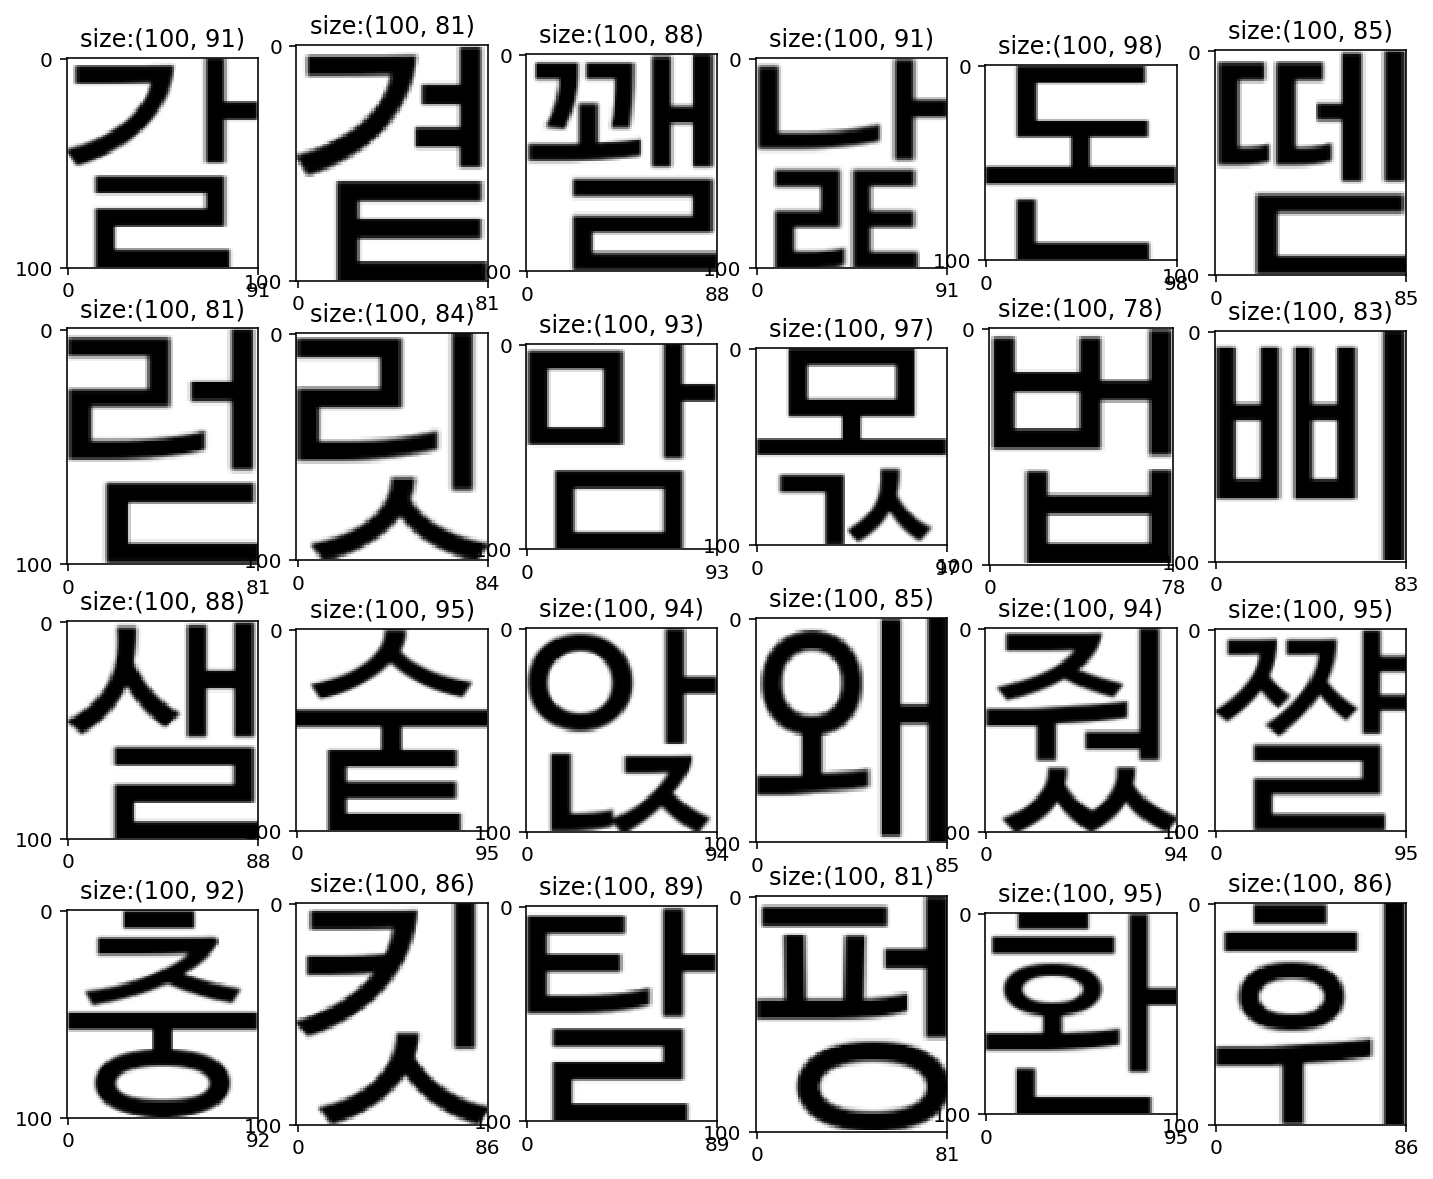

In [30]:
fontid = (0, 5)

plt.figure(figsize=(12, 10))
idx = 1
fake_images = np.array([grid_results[fontid][charid][0] for charid in fixed_char_ids])
for image in fake_images:
    image = image.cpu().detach().numpy()
    img, img_size = tight_crop_image(image.reshape(128, 128), resize_fix_h=100)
    plt.subplot(4, 6, idx)
    plt.imshow(img, cmap='gray')
    plt.title('size:' + str(img.shape))
    plt.xticks(np.linspace(0, img.shape[1], 2))
    plt.yticks(np.linspace(0, img.shape[0], 2))
    idx += 1
plt.show()

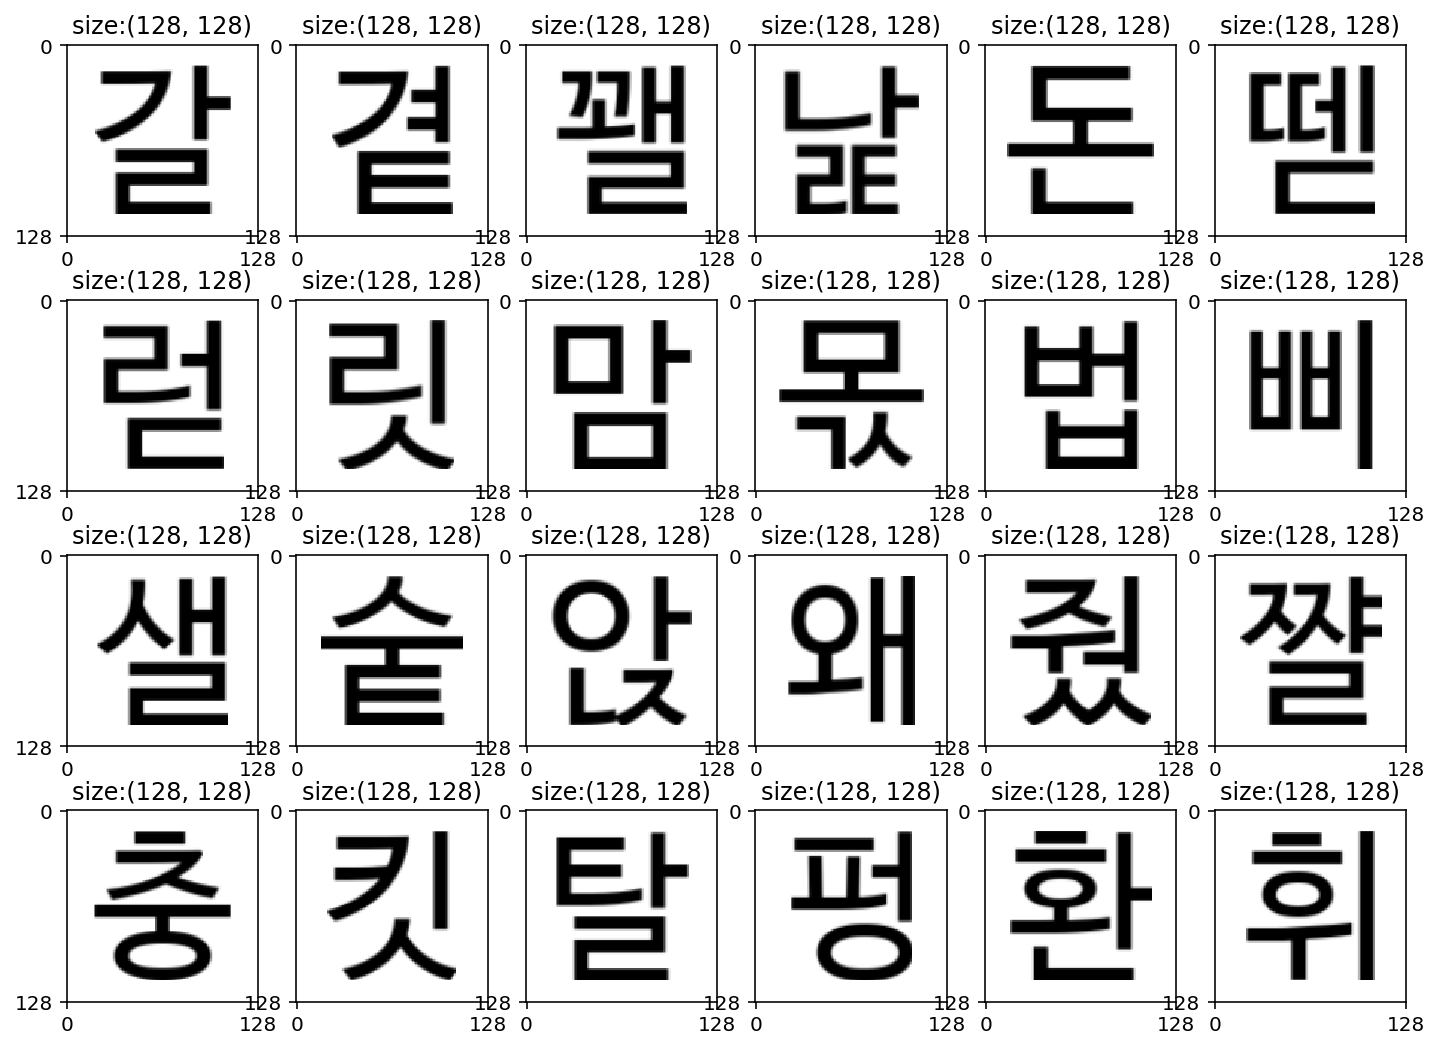

In [31]:
fontid = (0, 5)

plt.figure(figsize=(12, 9))
idx = 1
fake_images = np.array([grid_results[fontid][charid][0] for charid in fixed_char_ids])
for image in fake_images:
    image = image.cpu().detach().numpy()
    img, _ = tight_crop_image(image.reshape(128, 128), resize_fix_h=100)
    img = add_padding(img, pad_value=img[0][0])
    plt.subplot(4, 6, idx)
    plt.imshow(img, cmap='gray')
    plt.title('size:' + str(img.shape))
    plt.xticks(np.linspace(0, img.shape[1], 2))
    plt.yticks(np.linspace(0, img.shape[0], 2))
    idx += 1
plt.show()

- Centering, size matching 완료!